# City-Scale Holographic Traffic Flow Data based on Vehicular Trajectory Resampling

---

##  Overview

1. Trip Measurement
2. Trajectory Reconstruciton
3. Virtual Traffic Flow Detection
4. Data Validation

---

## 1. Trip Measurement

Trip measurement turns the partial observable LPR data into segmental trip data with certain paths on a constructed full-sensing road network (FSRN).

inputs: 
1. road network data (), 
2. signal data (),
3. LPR raw data ().

outputs:
* trip data


In [ ]:
import pandas as pd
import traj.network as network
import traj.trip_infer as ti
from traj.network import RdNet
from datetime import timedelta

# initiate road network (FSRN), read in traffic signal data, and LPR data.  
rd_net = RdNet('data/xc_net_with_len.csv')
ti.read_signal('data/sig.csv')
lpr_data = pd.read_csv('data/lpr_data.csv')

# for a pair of consecutive LPR data records, find the possible spatialtempero passing graph
end = max(lpr_data.index) + 1
for idx, row in lpr_data.iterrows():
    paths = ti.path(rd_net, row['up_rd'], row['dn_rd'])
    success = False
    for i in range(len(paths)) and not success:
        res = ti.checkPath(paths[i], row['ft'], row['tt'])
        success = res['accessible']
    print(str(idx + 1) + " of " + str(end) + " successed: " + str(success))
    


In [29]:
# rd_net.rd_data[rd_net.rd_data['cid']=='4393_4423']


,cid,nlane,turn,dnroad,geom,len,fn,tn
661,4393_4423,3,U#L#S,4423_4393#4423_4448#4423_4471,0105000020E61000000100000001020000000800000018...,612.797776,4393,4423


## 2. Trajectory Reconstruciton

Trajectory reconstructing interpolation is applied to each segment to form the holographic traffic flow data.

inputs: 
1. road network data (), 
2. signal data (),
3. trip data ().

outputs:
* vehicular trajectories

In [9]:
# backfoward reconstruction of vehicular trajectories.
#....

## 3. Virtual Traffic Flow Detection

One can run virtual traffic detection (P3) on holographic trajectories and resample various traffic flow data, including loop data and FCD data.

inputs:
1. road network data (), 
2. vehicular trajectories.

output:
1. loop data
2. FCD data


In [30]:
# fig traj 1/2
import psycopg2 as pg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import repeat
from decimal import Decimal
import geopandas as gpd
import pyproj

traj_conn = pg.connect(database="xcdb_basic", user="postgres", password="iamadmindonttry", host="172.18.190.25", port="5432")
sql = \
"select hphm::text||'_'||hpzl::text as cid, * from traj_sysu " + \
"where next_time >= '2020-09-15 08:00:00'::timestamp " + \
"  and time <= '2020-09-15 08:15:00'::timestamp " + \
"  and record_time > '2021-05-17 00:00:00'::timestamp " + \
"  and fnode = '4651' and tnode = '4635';"
df = pd.read_sql_query(sql,traj_conn)
df['posm'] = df['posm'].map(float)
df['next_posm'] = df['next_posm'].map(float)

map_conn = pg.connect(database="xc_site_2020", user="postgres", password="iamadmindonttry", host="172.18.190.25", port="5432")
node_sql = "select nodeid,type,'N'||nodeid as name, geom from topo_node where roadid isnull;"
nodes = gpd.read_postgis(node_sql, map_conn)
# nodes.crs = pyproj.CRS.from_user_input('EPSG:4326')
link_sql = "select id, mc, fnode, tnode, fnode::text||'_'||tnode::text as ftnode, st_length(geom, true) as length, geom from topo_centerroad;"
links = gpd.read_postgis(link_sql, map_conn)
# links.crs = pyproj.CRS.from_user_input('EPSG:4326')
links = links.set_crs(epsg=4326)
idx = links[links['ftnode'].isin(['4651_4635','4635_4651'])].index[0]
len = links['length'][idx]

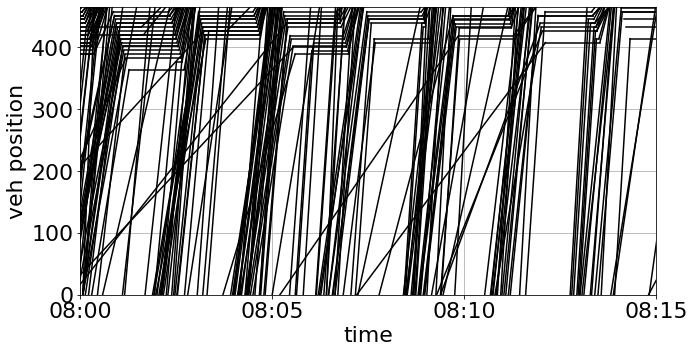

In [35]:
#fig traj 2/2

import matplotlib as mpl
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import Divider, Size
import matplotlib.dates as mdates


pick = df[((df['speed']>0) & (df['speed']<1)) | (df['speed']<0) | (df['speed']>33.33)]
df2 = df[~df.cid.isin(pick['cid'])]
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(10,6))
h = [Size.Fixed(1.0), Size.Scaled(1.), Size.Fixed(1.0)]
v = [Size.Fixed(1.0), Size.Scaled(1.), Size.Fixed(1.0)]
divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
ax = fig.add_axes(divider.get_position(),
                  axes_locator=divider.new_locator(nx=1, ny=1))

for i,row in df2.iterrows():
    plt.plot([row['time'],row['next_time']],[len-row['posm'],len-row['next_posm']],'k-')
ax.grid()
plt.xlim([pd.to_datetime('2020-09-15 08:00:00'),pd.to_datetime('2020-09-15 08:15:00')])
plt.ylim(0,len)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('time')
ax.set_ylabel('veh position')
plt.show()

loop detecting

fcd detecting

## 4. Data Validation

---

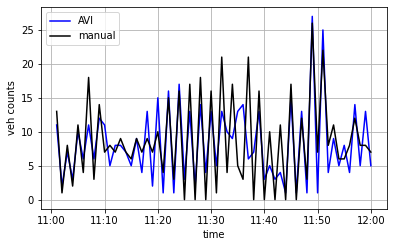

rmse=4.36272086355904
mape=54.301705553119575
corrcoef=0.7476122719183704


In [2]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import Divider, Size
import numpy as np
from sklearn.metrics import mean_squared_error

def dt(x, timeShift):
  y = timeShift+timedelta(microseconds=x)
  return y

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

def readManCount(file, timeShift):
    mc = pd.read_csv(file)
    tt = round(mc['t']/25.0*1e6).map(int)
    tt = tt.apply(lambda x: dt(x, timeShift))
    f = {'t':tt,'n':np.ones(len(tt))}
    f = pd.DataFrame(f)
    f = f.set_index(pd.to_datetime(f['t']))['n']
    o = f.resample("T").count()
    return o

o1 = readManCount('data/m_count.csv', datetime(2020,9,15,11,0,1))
o2 = readManCount('data/m_count_p2.csv', datetime(2020,9,15,11,36,0))
o = o1.append(o2)
    
    
cc = pd.read_csv('data/c_count_p2.csv')
cc['t'] = pd.to_datetime(cc['t'])
c = cc.set_index(cc['t'])['num']

fig = plt.figure(figsize=(6,4))
# ax = plt.axes()

# The first items are for padding and the second items are for the axes.
# sizes are in inch.
h = [Size.Fixed(1.0), Size.Scaled(1.), Size.Fixed(.2)]
v = [Size.Fixed(0.7), Size.Scaled(1.), Size.Fixed(.5)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
# The width and height of the rectangle are ignored.

ax = fig.add_axes(divider.get_position(),
                  axes_locator=divider.new_locator(nx=1, ny=1))

pc, = ax.plot(cc['t'],cc['num'],'b-',label="AVI")
pm, = ax.plot(o.index,o,'k-',label="manual")
ax.grid()
ax.legend()
# strftime('%Y-%m-%d %H:%M:%S')
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('time')
ax.set_ylabel('veh counts')
# plt.tight_layout()
plt.show()

print(f"rmse={np.sqrt(mean_squared_error(o, cc['num']))}")
print(f"mape={mape(o[o>0], c[o>0])}")
print(f"corrcoef={np.corrcoef(o, cc['num'])[0,1]}")

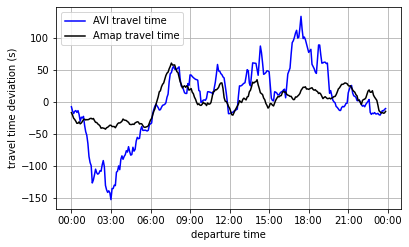

corrcoef=0.7491158269626307


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import Divider, Size
from scipy import stats
import numpy as np
from datetime import datetime, time, timedelta

d = pd.read_csv('data/trt_io_gd.csv')
t = pd.to_datetime(d['t'])
d['t2'] = [x.time() for x in t]
# d = d[(d['t2']>=time(6,0,0))&(d['t2']<time(20,0,0))]
t = pd.to_datetime(d['t'])
x = d['inout']
y = d['gd']


slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

def np_move_avg(a,n,mode="same"):
  return(np.convolve(a, np.ones((n,))/n, mode=mode))

mymodel = list(map(myfunc, x))

# plt.scatter(x, y)
# plt.plot(x, mymodel)
# plt.show()

xx = x-np.mean(x)
yy = y-np.mean(y)



# plt.figure()
# figure(figsize=(6,6))
# plt.xlim([0,400])
# plt.ylim([0,400])
# plt.plot(xx,yy,'.')

# print(r)

fig = plt.figure(figsize=(6,4))

# The first items are for padding and the second items are for the axes.
# sizes are in inch.
h = [Size.Fixed(1.0), Size.Scaled(1.), Size.Fixed(.2)]
v = [Size.Fixed(0.7), Size.Scaled(1.), Size.Fixed(.5)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
# The width and height of the rectangle are ignored.

ax = fig.add_axes(divider.get_position(),
                  axes_locator=divider.new_locator(nx=1, ny=1))


shown_x = np_move_avg(xx,10)
shown_y = np_move_avg(yy,10)
px = ax.plot(t,shown_x,'b-',label="AVI travel time")
py = ax.plot(t,shown_y,'k-',label="Amap travel time")
ax.grid()
ax.legend()
ax.set_xlabel('departure time')
ax.set_ylabel('travel time deviation (s)')

# format your data to desired format. Here I chose YYYY-MM-DD but you can set it to whatever you want.
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# # rotate and align the tick labels so they look better
# fig.autofmt_xdate()

# plt.tight_layout()
plt.show()

print(f"corrcoef={np.corrcoef(np_move_avg(xx,10),np_move_avg(yy,10))[0,1]}")

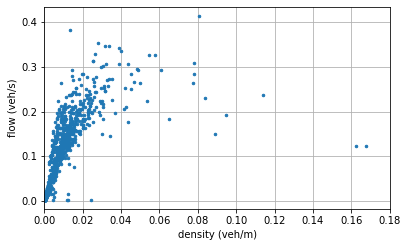

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

dataAll = pd.read_csv('data/fd_4651_4635_15min.csv',names=['t','q','v','k'])
dataAll['t'] = pd.to_datetime(dataAll['t'])

t_start = datetime(2020,9,12)
t_end = datetime(2020,9,19)
fd = dataAll[(dataAll.t>=t_start) & (dataAll.t<t_end)]
fd = fd[~((fd['v']<0) | (fd['v']>33.33))]

fd['time'] = [x.strftime('%H:%M') for x in fd['t']]
dawn = '06:00'
dusk = '18:00'
fd_dark = fd[(((fd['time']<dawn)|(fd['time']>=dusk)))&(fd['v']<12.0)]
fd_light = fd[(((fd['time']>=dawn)&(fd['time']<dusk))|(fd['v']>12.0))]


fig = plt.figure(figsize=(6,4))

h = [Size.Fixed(1.0), Size.Scaled(1.), Size.Fixed(.2)]
v = [Size.Fixed(0.7), Size.Scaled(1.), Size.Fixed(.5)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
# The width and height of the rectangle are ignored.

ax = fig.add_axes(divider.get_position(),
                  axes_locator=divider.new_locator(nx=1, ny=1))

ax.plot(fd['k'], fd['q'], '.', markersize=5)
ax.set_xlim(0,0.18)
ax.grid()
ax.set_xlabel('density (veh/m)')
ax.set_ylabel('flow (veh/s)')

plt.show()

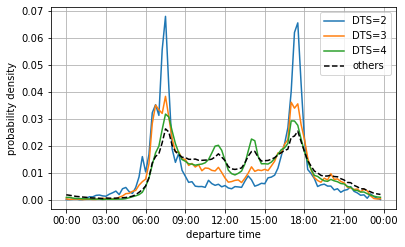

In [7]:
import json
# lt = json.load(open('trip_stat/veh_labeltq.json'))
# la = json.load(open('trip_stat/veh_label_3_9.json'))
ts = pd.read_csv('data/time_slot.csv')
ts['time_slot'] = pd.to_datetime(ts['time_slot'])

fig = plt.figure(figsize=(6,4))

# sizes are in inch.
h = [Size.Fixed(1.0), Size.Scaled(1.), Size.Fixed(.2)]
v = [Size.Fixed(0.7), Size.Scaled(1.), Size.Fixed(.5)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
# The width and height of the rectangle are ignored.

ax = fig.add_axes(divider.get_position(),
                  axes_locator=divider.new_locator(nx=1, ny=1))

py = ax.plot(ts['time_slot'],ts['T2'],label="DTS=2")
py = ax.plot(ts['time_slot'],ts['T3'],label="DTS=3")
py = ax.plot(ts['time_slot'],ts['T4'],label="DTS=4")
py = ax.plot(ts['time_slot'],ts['other'],'k--',label="others")
# py = ax.plot(ts['time_slot'],ts['T4'],'o-',label="zongti")

# format your data to desired format. Here I chose YYYY-MM-DD but you can set it to whatever you want.
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax.grid()
ax.set_xlabel('departure time')
ax.set_ylabel('probability density')
ax.legend()
plt.show()